In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

import cv2
from tqdm import tqdm
import io
import seaborn as sns

from sklearn.utils import shuffle # Shuffle arrays or sparse matrices in a consistent way
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications import DenseNet121
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard,ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras.utils.vis_utils import plot_model

import ipywidgets as widgets
from PIL import Image
from IPython.display import display, clear_output

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Define Labels

In [3]:
labels = ['Final AD JPEG','Final CN JPEG', 'Final EMCI JPEG', 'Final LMCI JPEG','Final MCI JPEG']

In [4]:
X_train = [] #Training Dataset
Y_train = [] #Training Labels

image_size=150

for i in labels:
    folderPath = os.path.join('/kaggle/input/alzheimers-adni/Alzheimers-ADNI/', 'train', i)
    for j in tqdm(os.listdir(folderPath)):
        image = cv2.imread(os.path.join(folderPath, j))
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(i)
        
        
for i in labels:
    folderPath = os.path.join('/kaggle/input/alzheimers-adni/Alzheimers-ADNI', 'test', i) # Join two or more pathname components
    for j in tqdm(os.listdir(folderPath)):
        image = cv2.imread(os.path.join(folderPath, j))
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(i)
        
# converted into array

Xtrain = np.array(X_train)
Ytrain = np.array(Y_train)

100%|██████████| 233/233 [00:01<00:00, 157.62it/s]


In [5]:
Xtrain.shape

(18775, 150, 150, 3)

In [6]:
Ytrain.shape

(18775,)

In [7]:
Xtrain, Ytrain = shuffle(Xtrain, Ytrain, random_state=42)

## Train test split which is divided train dataset and validation dataset

In [8]:
xtrain,xtest, Ytrain,ytest = train_test_split(Xtrain, Ytrain,test_size=0.3, random_state=42)

In [9]:
xtrain.shape

(13142, 150, 150, 3)

In [10]:
Ytrain.shape

(13142,)

In [11]:
xtest.shape

(5633, 150, 150, 3)

In [12]:
ytest.shape

(5633,)

## Converting labels into One hot encoder

In [13]:
ytrain_new = []
ytest_new = []

for i in Ytrain:
    ytrain_new.append(labels.index(i))#Converting String Label to integer i.e
                                       
ytrain = to_categorical(ytrain_new) #Converts a class vector (integers) to binary class matrix

for i in ytest:
    ytest_new.append(labels.index(i))

ytest = to_categorical(ytest_new)

In [14]:
ytrain.shape

(13142, 5)

In [15]:
ytest.shape

(5633, 5)

# DENSENET MODEL

In [16]:
model_d=DenseNet121(weights='imagenet',include_top=False, input_shape=(image_size, image_size, 3)) 

29084464/29084464 [==============================] - 2s 0us/step


In [17]:
# Output of model

model = model_d.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(0.5)(model)
model = tf.keras.layers.Dense(5, activation='softmax')(model)
model = tf.keras.models.Model(inputs=model_d.input, outputs=model)

In [18]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc')
]

In [19]:
model.compile( optimizer='adam',
    loss='categorical_crossentropy',
    metrics=METRICS)

In [20]:
history = model.load_weights('/kaggle/input/model-training/Model Training/densenet.h5')

In [21]:
labels_final = ['AD','CN','EMCI','LMCI','MCI']

In [22]:
pred = model.predict(xtest)
pred = np.argmax(pred, axis=1)
actual_label = np.argmax(ytest, axis=1)
print(classification_report(actual_label, pred , target_names = labels))

177/177 [==============================] - 12s 29ms/step
                 precision    recall  f1-score   support

  Final AD JPEG       0.99      0.93      0.96      2481
  Final CN JPEG       0.94      0.98      0.96      2603
Final EMCI JPEG       0.57      0.78      0.66       130
Final LMCI JPEG       0.78      0.65      0.71        43
 Final MCI JPEG       0.83      0.76      0.80       376

       accuracy                           0.94      5633
      macro avg       0.82      0.82      0.82      5633
   weighted avg       0.94      0.94      0.94      5633



In [23]:
accuracy_score(actual_label, pred)

0.938398721817859

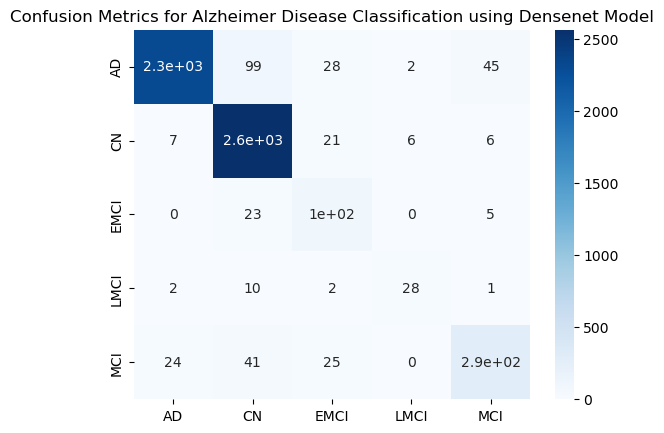

In [24]:
Cm=confusion_matrix(actual_label,pred)
ax=plt.axes()
sns.heatmap(Cm, cmap='Blues' ,annot=True,
           annot_kws={'size':10},
           xticklabels=labels_final,
           yticklabels=labels_final,
           ax=ax
           )

plt.title("Confusion Metrics for Alzheimer Disease Classification using Densenet Model")
plt.savefig('densenet_confusion.png', dpi=300) # Save plot as PNG
plt.show()

## Loss and Accuracy Measurement graph

In [25]:
import pickle

with open('/kaggle/input/model-training/Model Training/densenet_history.pkl', 'rb') as f:
    history = pickle.load(f)

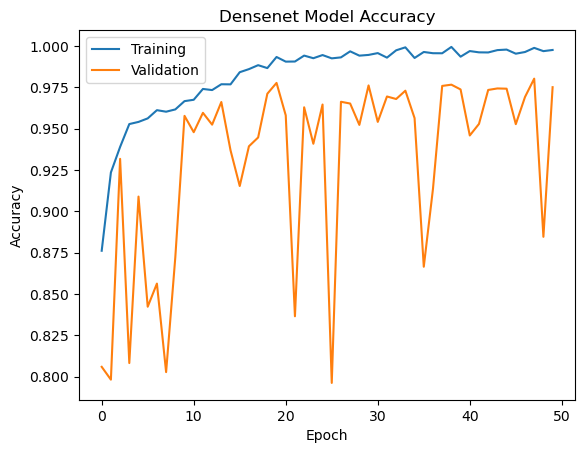

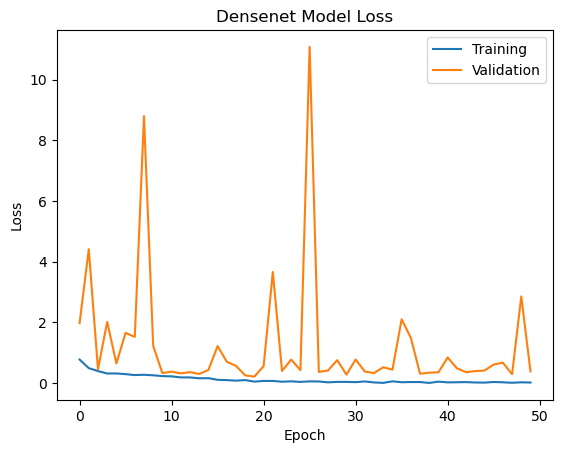

In [26]:
# Plot the training and validation accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Densenet Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.savefig('densenet_accuracy.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Densenet Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.savefig('densenet_loss.png', dpi=300) # Save plot as PNG
plt.show()

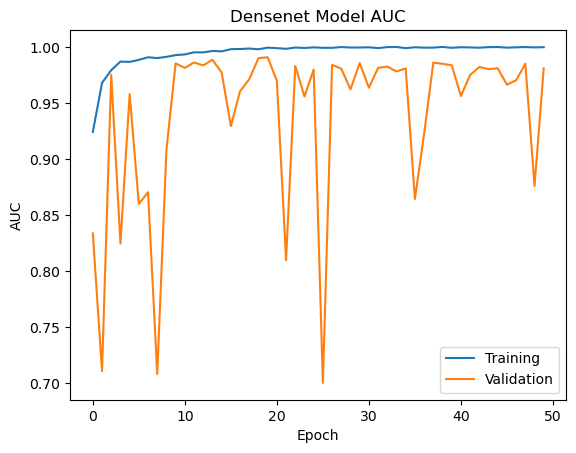

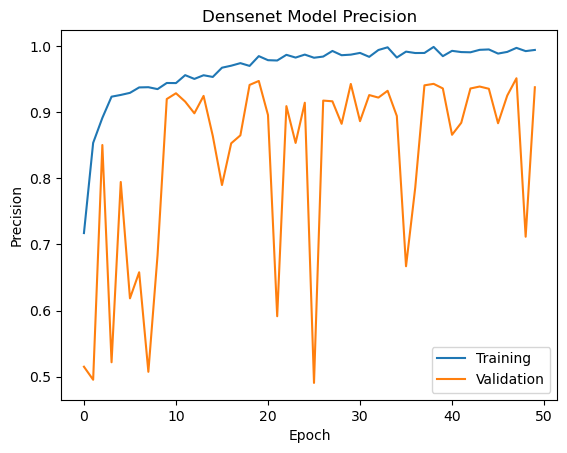

In [27]:
# Plot the training and validation auc
plt.plot(history['auc'])
plt.plot(history['val_auc'])
plt.title('Densenet Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(['Training', 'Validation'])
plt.savefig('densenet_auc.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation precision
plt.plot(history['precision'])
plt.plot(history['val_precision'])
plt.title('Densenet Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Training', 'Validation'])
plt.savefig('densenet_precision.png', dpi=300) # Save plot as PNG
plt.show()

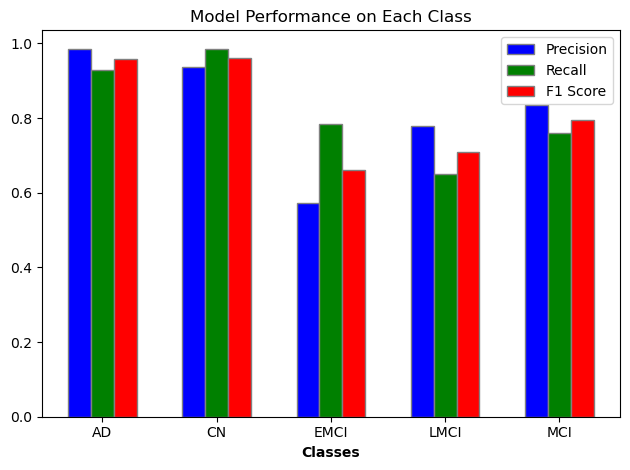

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Get classification report
report = classification_report(actual_label, pred, target_names=labels_final, output_dict=True)

# Extract metrics
precision = [report[label]['precision'] for label in labels_final]
recall = [report[label]['recall'] for label in labels_final]
f1_score = [report[label]['f1-score'] for label in labels_final]

# Bar width
bar_width = 0.2

# Set positions of bar on X axis
r1 = np.arange(len(labels_final))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create bars
plt.bar(r1, precision, color='b', width=bar_width, edgecolor='grey', label='Precision')
plt.bar(r2, recall, color='g', width=bar_width, edgecolor='grey', label='Recall')
plt.bar(r3, f1_score, color='r', width=bar_width, edgecolor='grey', label='F1 Score')

# Add xticks on the middle of the group bars
plt.xlabel('Classes', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(labels_final))], labels_final)

# Create legend & Show graphic
plt.title('Model Performance on Each Class')
plt.legend()
plt.tight_layout()
plt.show()


## CNN MODEL

In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import layers

model1 = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(image_size, image_size, 3)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')
])

In [30]:
model1.compile( optimizer='adam',
    loss='categorical_crossentropy',
    metrics=METRICS)

In [31]:
history1 = model1.load_weights('/kaggle/input/model-training/Model Training/cnn.h5')


In [32]:
pred1 = model1.predict(xtest)
pred1 = np.argmax(pred1, axis=1)
actual_label1 = np.argmax(ytest, axis=1)
print(classification_report(actual_label1, pred1 , target_names = labels_final))

177/177 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

          AD       0.95      0.89      0.92      2481
          CN       0.89      0.97      0.93      2603
        EMCI       0.77      0.63      0.69       130
        LMCI       1.00      0.65      0.79        43
         MCI       0.86      0.71      0.78       376

    accuracy                           0.91      5633
   macro avg       0.89      0.77      0.82      5633
weighted avg       0.91      0.91      0.91      5633



In [33]:
accuracy_score(actual_label1, pred1)

0.9098171489437245

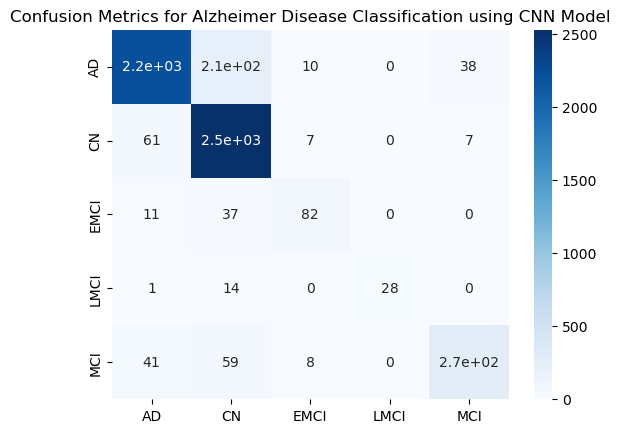

In [34]:
Cm1=confusion_matrix(actual_label1,pred1)
ax1=plt.axes()
sns.heatmap(Cm1, cmap='Blues' ,annot=True,
           annot_kws={'size':10},
           xticklabels=labels_final,
           yticklabels=labels_final,
           ax=ax1
           )

plt.title("Confusion Metrics for Alzheimer Disease Classification using CNN Model")
plt.savefig('cnn_confusion.png', dpi=300) # Save plot as PNG
plt.show()

## Loss and Accuracy Measurement Graph - CNN Model

In [35]:
import pickle

with open('/kaggle/input/model-training/Model Training/cnn_history.pkl', 'rb') as f:
    history1 = pickle.load(f)


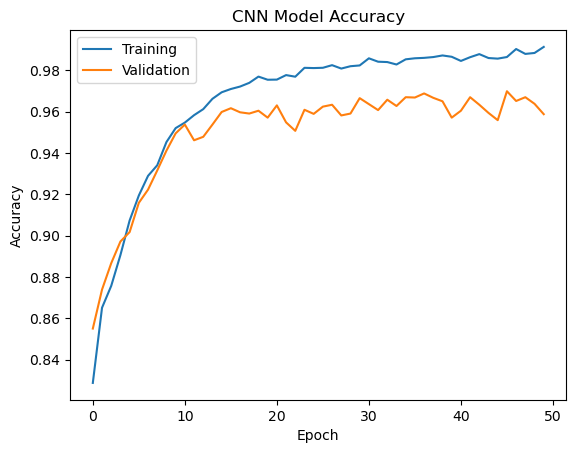

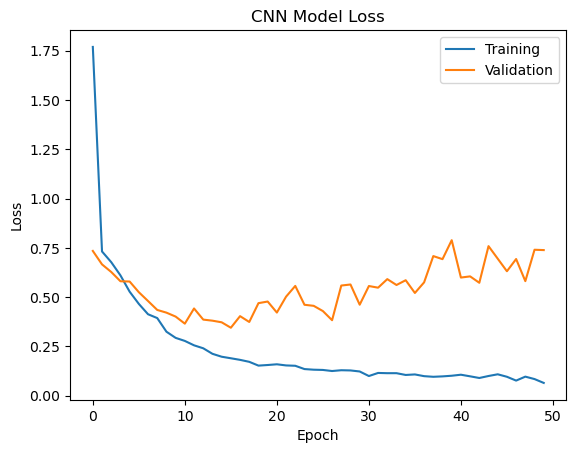

In [36]:
# Plot the training and validation accuracy
plt.plot(history1['accuracy'])
plt.plot(history1['val_accuracy'])
plt.title('CNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.savefig('cnn_accuracy.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation loss
plt.plot(history1['loss'])
plt.plot(history1['val_loss'])
plt.title('CNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.savefig('cnn_loss.png', dpi=300) # Save plot as PNG
plt.show()

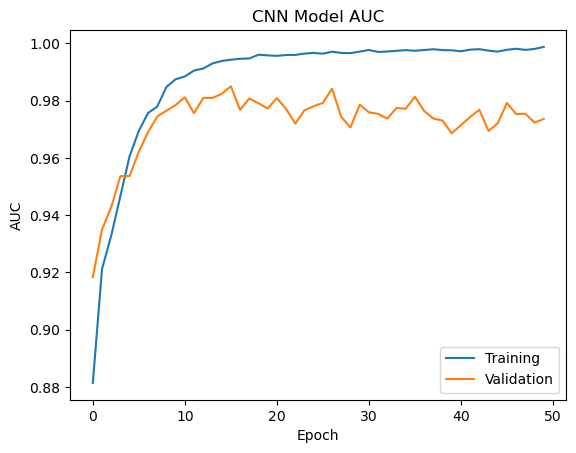

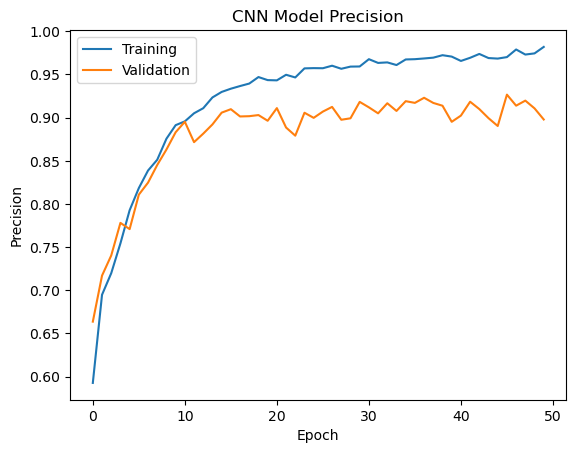

In [37]:
# Plot the training and validation auc
plt.plot(history1['auc'])
plt.plot(history1['val_auc'])
plt.title('CNN Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(['Training', 'Validation'])
plt.savefig('cnn_auc.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation precision
plt.plot(history1['precision'])
plt.plot(history1['val_precision'])
plt.title('CNN Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Training', 'Validation'])
plt.savefig('cnn_precision.png', dpi=300) # Save plot as PNG
plt.show()

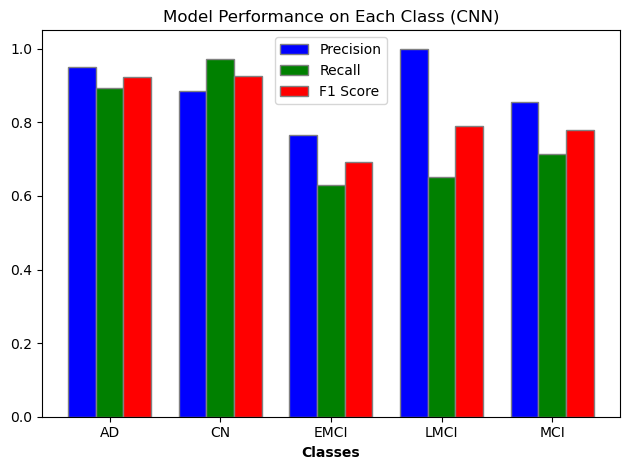

In [38]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

# Get classification report
report = classification_report(actual_label1, pred1, target_names=labels_final, output_dict=True)

# Extract metrics
precision = [report[label]['precision'] for label in labels_final]
recall = [report[label]['recall'] for label in labels_final]
f1_score = [report[label]['f1-score'] for label in labels_final]

# Bar width
bar_width = 0.25

# Set positions of bar on X axis
r1 = np.arange(len(labels_final))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create bars
plt.bar(r1, precision, color='b', width=bar_width, edgecolor='grey', label='Precision')
plt.bar(r2, recall, color='g', width=bar_width, edgecolor='grey', label='Recall')
plt.bar(r3, f1_score, color='r', width=bar_width, edgecolor='grey', label='F1 Score')

# Add xticks on the middle of the group bars
plt.xlabel('Classes', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(labels_final))], labels_final)

# Create legend & Show graphic
plt.title('Model Performance on Each Class (CNN)')
plt.legend()
plt.tight_layout()
plt.show()


## Efficient NetB7 Model

In [39]:
from tensorflow.keras.applications import EfficientNetB7

In [40]:
efficientnetB7= EfficientNetB7(include_top=False,weights='imagenet',input_shape=(image_size, image_size, 3))

258076736/258076736 [==============================] - 11s 0us/step


In [41]:
# Output of model

model2 = efficientnetB7.output
model2 = tf.keras.layers.GlobalAveragePooling2D()(model2)
model2 = tf.keras.layers.Dropout(0.3)(model2)
model2 = tf.keras.layers.Dense(5, activation='softmax')(model2)
model2 = tf.keras.models.Model(inputs=efficientnetB7.input, outputs=model2)

In [42]:
model2.compile( optimizer='adam',
    loss='categorical_crossentropy',
    metrics=METRICS)

In [43]:
history2 = model2.load_weights('/kaggle/input/model-training/Model Training/efficientb7.h5')

In [44]:
import pickle

with open('/kaggle/input/model-training/Model Training/efficientb7_history.pkl', 'rb') as f:
    history2 = pickle.load(f)


In [45]:
pred2 = model2.predict(xtest)
pred2 = np.argmax(pred2, axis=1)
actual_label2 = np.argmax(ytest, axis=1)
print(classification_report(actual_label2, pred2,target_names = labels_final))

177/177 [==============================] - 27s 123ms/step
              precision    recall  f1-score   support

          AD       0.96      0.97      0.97      2481
          CN       0.97      0.98      0.97      2603
        EMCI       0.77      0.72      0.75       130
        LMCI       0.67      0.65      0.66        43
         MCI       0.82      0.73      0.77       376

    accuracy                           0.95      5633
   macro avg       0.84      0.81      0.82      5633
weighted avg       0.95      0.95      0.95      5633



In [46]:
accuracy_score(actual_label2, pred2)

0.9515355938221196

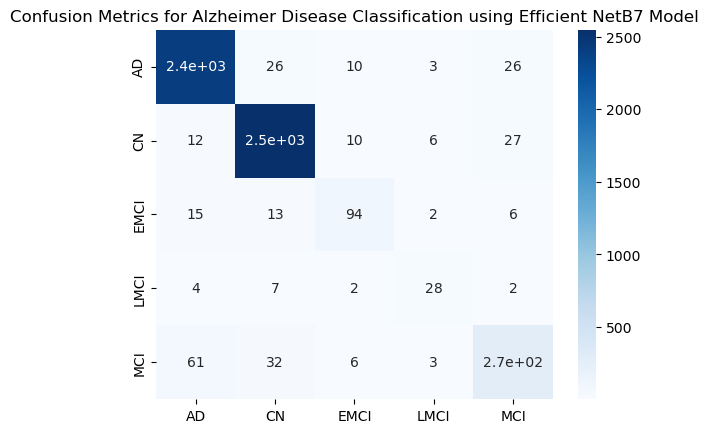

In [47]:
Cm2=confusion_matrix(actual_label2,pred2)
ax2=plt.axes()
sns.heatmap(Cm2, cmap='Blues' ,annot=True,
           annot_kws={'size':10},
           xticklabels=labels_final,
           yticklabels=labels_final,
           ax=ax2
           )

plt.title("Confusion Metrics for Alzheimer Disease Classification using Efficient NetB7 Model")
plt.savefig('netb7_confusion.png', dpi=300) # Save plot as PNG
plt.show()

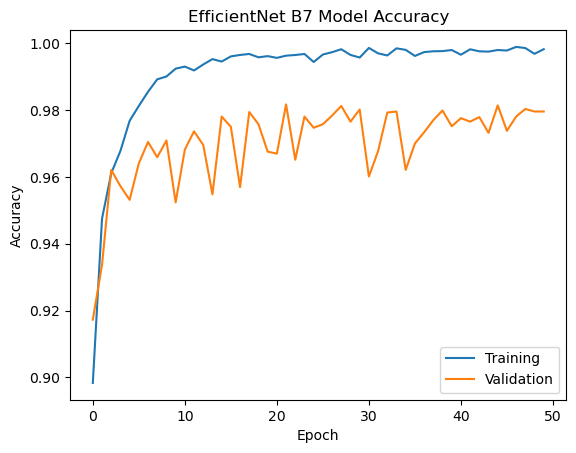

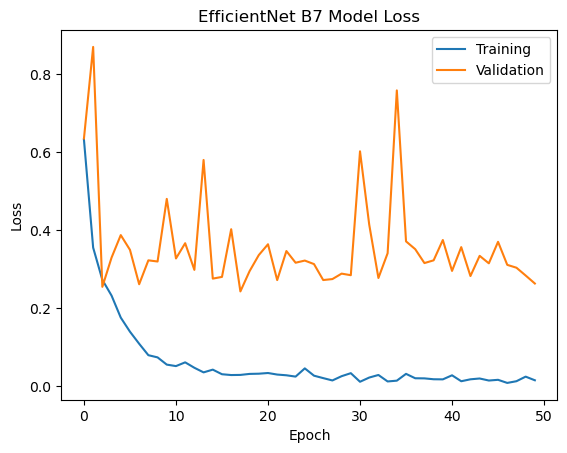

In [48]:
# Plot the training and validation accuracy
plt.plot(history2['accuracy'])
plt.plot(history2['val_accuracy'])
plt.title('EfficientNet B7 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.savefig('netb7_accuracy.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation loss
plt.plot(history2['loss'])
plt.plot(history2['val_loss'])
plt.title('EfficientNet B7 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.savefig('netb7_loss.png', dpi=300) # Save plot as PNG
plt.show()

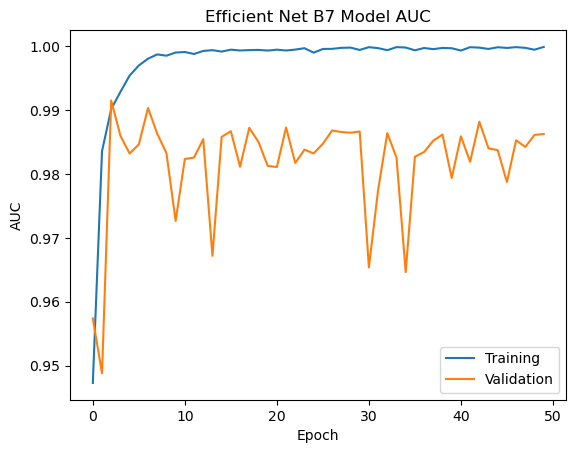

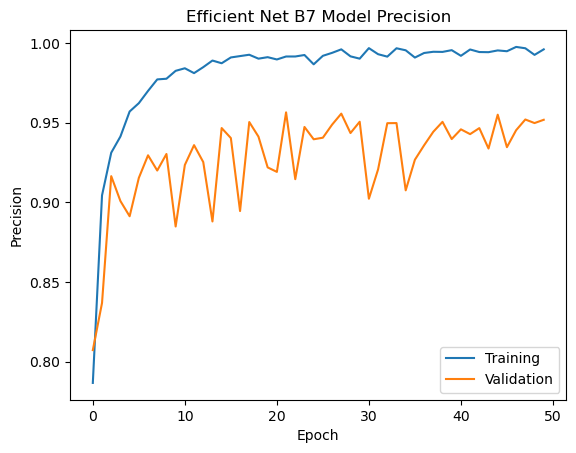

In [49]:
# Plot the training and validation auc
plt.plot(history2['auc'])
plt.plot(history2['val_auc'])
plt.title('Efficient Net B7 Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(['Training', 'Validation'])
plt.savefig('netb7_auc.png', dpi=300) # Save plot as PNG

plt.show()

# Plot the training and validation precision
plt.plot(history2['precision'])
plt.plot(history2['val_precision'])
plt.title('Efficient Net B7 Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Training', 'Validation'])
plt.savefig('netb7_precision.png', dpi=300) # Save plot as PNG
plt.show()

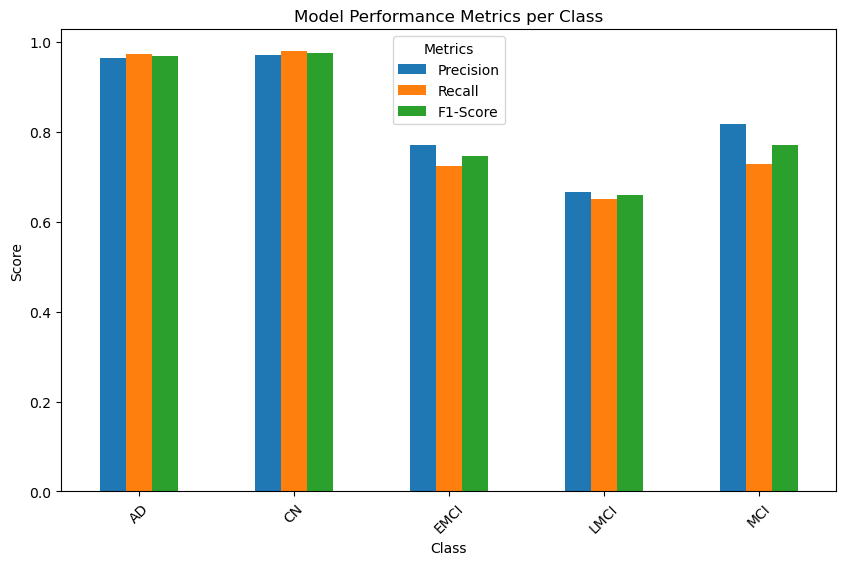

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get metrics from classification report
report = classification_report(actual_label2, pred2, target_names=labels_final, output_dict=True)

# Extract precision, recall, and f1-score
precision = [report[label]['precision'] for label in labels_final]
recall = [report[label]['recall'] for label in labels_final]
f1_score = [report[label]['f1-score'] for label in labels_final]

# Create a DataFrame for easier plotting
metrics_df = pd.DataFrame({
    'Class': labels_final,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1_score
})

# Set the class names as index
metrics_df.set_index('Class', inplace=True)

# Plotting
metrics_df.plot(kind='bar', figsize=(10, 6))
plt.title('Model Performance Metrics per Class')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(title='Metrics')
plt.savefig('model_performance_per_class.png', dpi=300)
plt.show()


# VGG19 MODEL

In [51]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(weights='imagenet',
            include_top = False,input_shape=(image_size, image_size, 3)
           )
for layer in vgg.layers:
    layer.trainable = False
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model3 = Sequential()
model3.add(vgg)
model3.add(Flatten())
model3.add(Dense(5,activation="softmax"))
# model.summary()

80134624/80134624 [==============================] - 4s 0us/step


## Compile VGG19 Model

In [52]:
model3.compile( optimizer='adam',
    loss='categorical_crossentropy',
    metrics=METRICS)

In [53]:
history3 = model3.load_weights('/kaggle/input/model-training/Model Training/vgg19.h5')

In [54]:
import pickle

with open('/kaggle/input/model-training/Model Training/vgg19_history.pkl', 'rb') as f:
    history3 = pickle.load(f)


In [55]:
pred3 = model3.predict(xtest)
pred3 = np.argmax(pred3, axis=1)
actual_label3 = np.argmax(ytest, axis=1)
print(classification_report(actual_label3, pred3, target_names = labels_final))

177/177 [==============================] - 8s 38ms/step
              precision    recall  f1-score   support

          AD       0.80      0.95      0.87      2481
          CN       0.94      0.82      0.88      2603
        EMCI       0.74      0.62      0.67       130
        LMCI       0.67      0.65      0.66        43
         MCI       0.83      0.57      0.68       376

    accuracy                           0.86      5633
   macro avg       0.80      0.72      0.75      5633
weighted avg       0.86      0.86      0.85      5633



In [56]:
accuracy_score(actual_label3, pred3)

0.8554944079531334

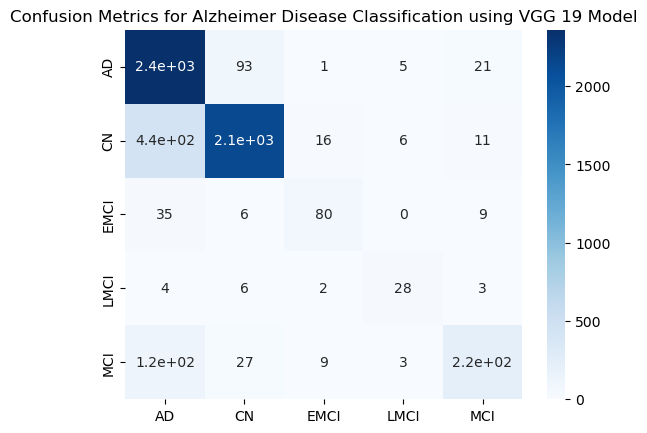

In [57]:
Cm3=confusion_matrix(actual_label3,pred3)
ax3=plt.axes()
sns.heatmap(Cm3, cmap='Blues' ,annot=True,
           annot_kws={'size':10},
           xticklabels=labels_final,
           yticklabels=labels_final,
           ax=ax3
           )

plt.title("Confusion Metrics for Alzheimer Disease Classification using VGG 19 Model")
plt.savefig('vgg19_confusion.png', dpi=300) # Save plot as PNG
plt.show()

## Loss and Accuracy Measurement Graph - VGG19 Model

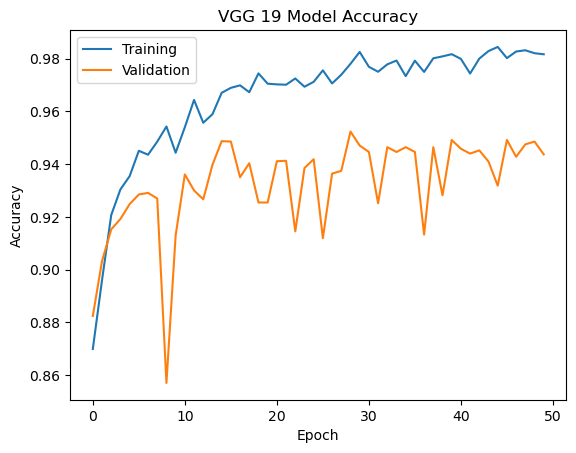

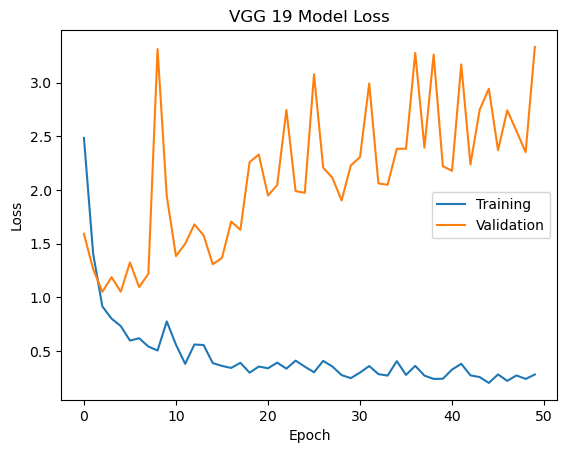

In [58]:
# Plot the training and validation accuracy
plt.plot(history3['accuracy'])
plt.plot(history3['val_accuracy'])
plt.title('VGG 19 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.savefig('vgg19_accuracy.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation loss
plt.plot(history3['loss'])
plt.plot(history3['val_loss'])
plt.title('VGG 19 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.savefig('vgg19_loss.png', dpi=300) # Save plot as PNG
plt.show()

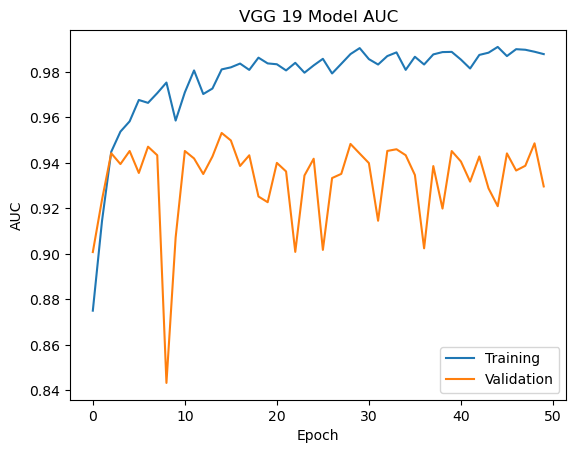

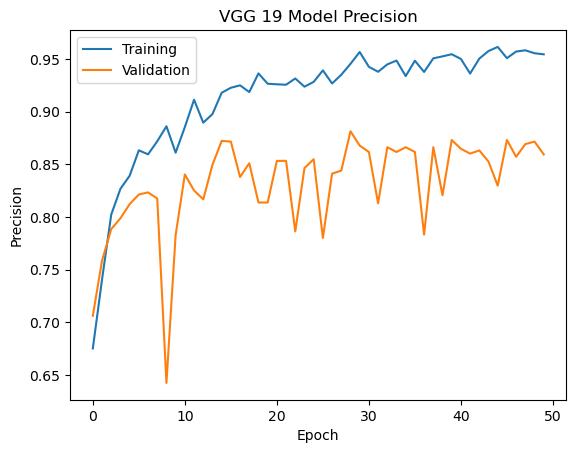

In [59]:
# Plot the training and validation auc
plt.plot(history3['auc'])
plt.plot(history3['val_auc'])
plt.title('VGG 19 Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(['Training', 'Validation'])
plt.savefig('vgg19_auc.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation precision
plt.plot(history3['precision'])
plt.plot(history3['val_precision'])
plt.title('VGG 19 Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Training', 'Validation'])
plt.savefig('vgg19_precision.png', dpi=300) # Save plot as PNG
plt.show()

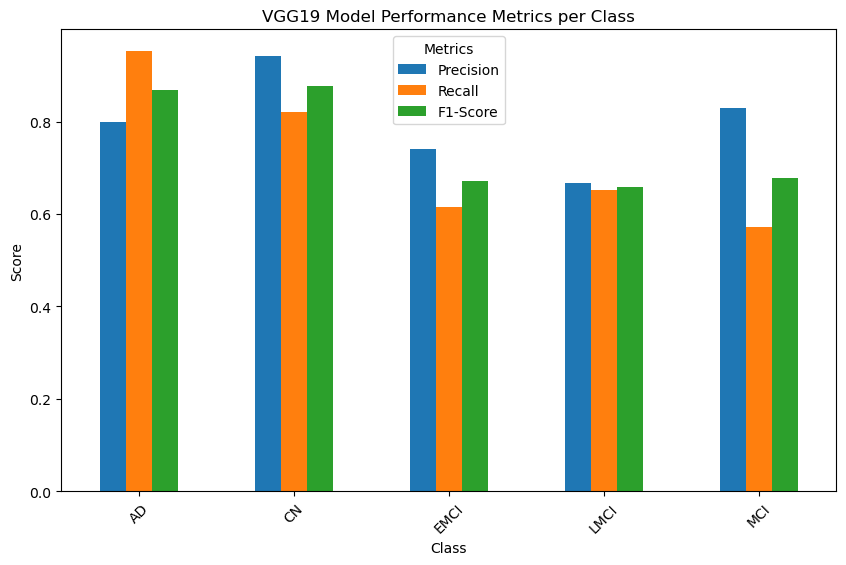

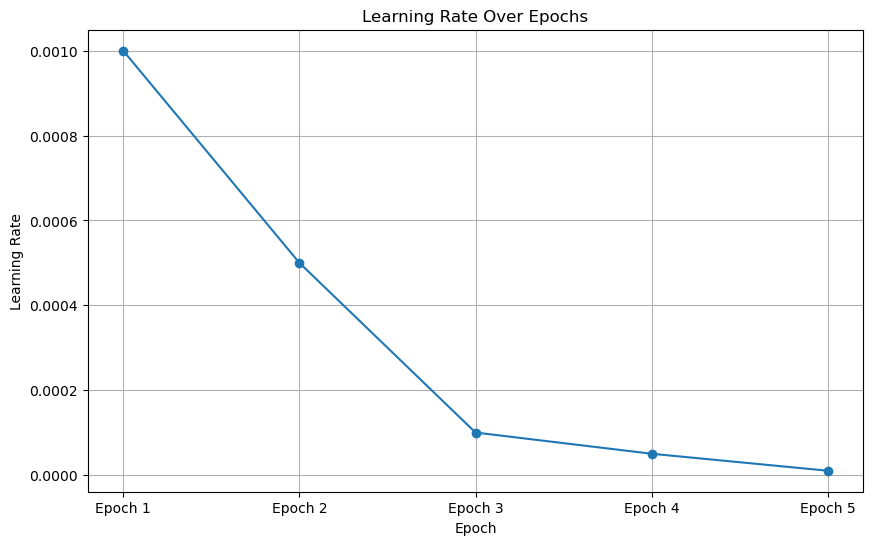

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get metrics from classification report
report = classification_report(actual_label3, pred3, target_names=labels_final, output_dict=True)

# Extract precision, recall, and f1-score
precision = [report[label]['precision'] for label in labels_final]
recall = [report[label]['recall'] for label in labels_final]
f1_score = [report[label]['f1-score'] for label in labels_final]

# Create a DataFrame for easier plotting
metrics_df = pd.DataFrame({
    'Class': labels_final,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1_score
})

# Set the class names as index
metrics_df.set_index('Class', inplace=True)

# Plotting the performance metrics
metrics_df.plot(kind='bar', figsize=(10, 6))
plt.title('VGG19 Model Performance Metrics per Class')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(title='Metrics')
plt.savefig('vgg19_model_performance_per_class.png', dpi=300)
plt.show()

# Assuming you have a learning rate history (this is just an example)
# You might need to replace this with the actual learning rate data
learning_rate_history = [0.001, 0.0005, 0.0001, 0.00005, 0.00001]  # Example values
epochs = len(learning_rate_history)

# Plotting the learning rate
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), learning_rate_history, marker='o')
plt.title('Learning Rate Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.xticks(range(epochs), [f'Epoch {i+1}' for i in range(epochs)])  # Adjust for actual epoch labels if needed
plt.grid()
plt.savefig('vgg19_learning_rate.png', dpi=300)
plt.show()


Define Image Size and Prepare Data

ResNet Model

In [61]:
import numpy as np
import os
import cv2
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
tf.random.set_seed(42)


In [62]:
labels = ['Final AD JPEG', 'Final CN JPEG', 'Final EMCI JPEG', 'Final LMCI JPEG', 'Final MCI JPEG']
X_train = []
Y_train = []

image_size = 150

# Load training data
for label in labels:
    folderPath = os.path.join('/kaggle/input/alzheimers-adni/Alzheimers-ADNI/train', label)
    for file in tqdm(os.listdir(folderPath)):
        image = cv2.imread(os.path.join(folderPath, file))
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(label)

# Load test data
for label in labels:
    folderPath = os.path.join('/kaggle/input/alzheimers-adni/Alzheimers-ADNI/test', label)
    for file in tqdm(os.listdir(folderPath)):
        image = cv2.imread(os.path.join(folderPath, file))
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(label)

# Convert to arrays
X_train = np.array(X_train)
Y_train = np.array(Y_train)

# Shuffle the data
X_train, Y_train = shuffle(X_train, Y_train, random_state=42)

# Split the dataset
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3, random_state=42)

# Convert string labels to integer and then to categorical
y_train = to_categorical([labels.index(label) for label in y_train])
y_test = to_categorical([labels.index(label) for label in y_test])
labels = ['Final AD JPEG', 'Final CN JPEG', 'Final EMCI JPEG', 'Final LMCI JPEG', 'Final MCI JPEG']
X_train = []
Y_train = []

image_size = 150

# Load training data
for label in labels:
    folderPath = os.path.join('/kaggle/input/alzheimers-adni/Alzheimers-ADNI/train', label)
    for file in tqdm(os.listdir(folderPath)):
        image = cv2.imread(os.path.join(folderPath, file))
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(label)

# Load test data
for label in labels:
    folderPath = os.path.join('/kaggle/input/alzheimers-adni/Alzheimers-ADNI/test', label)
    for file in tqdm(os.listdir(folderPath)):
        image = cv2.imread(os.path.join(folderPath, file))
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(label)

# Convert to arrays
X_train = np.array(X_train)
Y_train = np.array(Y_train)

# Shuffle the data
X_train, Y_train = shuffle(X_train, Y_train, random_state=42)

# Split the dataset
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3, random_state=42)

# Convert string labels to integer and then to categorical
y_train = to_categorical([labels.index(label) for label in y_train])
y_test = to_categorical([labels.index(label) for label in y_test])


100%|██████████| 233/233 [00:00<00:00, 597.09it/s]


In [63]:
from tensorflow.keras.applications import ResNet50

def create_resnet_model(input_shape, num_classes):
    base_model = ResNet50(weights=None, include_top=False, input_shape=input_shape)
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

input_shape = (image_size, image_size, 3)
num_classes = len(labels)
model_resnet = create_resnet_model(input_shape, num_classes)


In [64]:
model_resnet.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])


In [65]:
# Define callbacks
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(patience=5, factor=0.5),
    ModelCheckpoint('resnet_model.h5', save_best_only=True)
]

# Train the model
history = model_resnet.fit(x_train, y_train,
                            validation_split=0.2,
                            epochs=25,
                            batch_size=32,
                            callbacks=callbacks)


Epoch 1/25
329/329 [==============================] - 74s 118ms/step - loss: 1.0466 - accuracy: 0.5793 - val_loss: 1.2681 - val_accuracy: 0.4481 - lr: 0.0010
Epoch 2/25
329/329 [==============================] - 37s 113ms/step - loss: 0.6909 - accuracy: 0.7023 - val_loss: 0.9211 - val_accuracy: 0.6246 - lr: 0.0010
Epoch 3/25
329/329 [==============================] - 37s 113ms/step - loss: 0.5233 - accuracy: 0.7814 - val_loss: 0.8413 - val_accuracy: 0.7326 - lr: 0.0010
Epoch 4/25
329/329 [==============================] - 36s 109ms/step - loss: 0.4608 - accuracy: 0.8138 - val_loss: 1.5756 - val_accuracy: 0.5029 - lr: 0.0010
Epoch 5/25
329/329 [==============================] - 36s 109ms/step - loss: 0.3920 - accuracy: 0.8418 - val_loss: 2.8201 - val_accuracy: 0.4823 - lr: 0.0010
Epoch 6/25
329/329 [==============================] - 37s 112ms/step - loss: 0.3829 - accuracy: 0.8495 - val_loss: 0.4967 - val_accuracy: 0.8087 - lr: 0.0010
Epoch 7/25
329/329 [==============================] 

In [66]:
# Evaluate on the test set
predictions = model_resnet.predict(x_test)
predictions_classes = np.argmax(predictions, axis=1)
actual_classes = np.argmax(y_test, axis=1)

# Print classification report and accuracy
print(classification_report(actual_classes, predictions_classes, target_names=labels))
print(f'Accuracy: {accuracy_score(actual_classes, predictions_classes)}')


177/177 [==============================] - 6s 30ms/step
                 precision    recall  f1-score   support

  Final AD JPEG       0.95      0.96      0.95      2481
  Final CN JPEG       0.94      0.96      0.95      2603
Final EMCI JPEG       0.42      0.40      0.41       130
Final LMCI JPEG       0.38      0.07      0.12        43
 Final MCI JPEG       0.66      0.56      0.61       376

       accuracy                           0.91      5633
      macro avg       0.67      0.59      0.61      5633
   weighted avg       0.91      0.91      0.91      5633

Accuracy: 0.9139002307828865


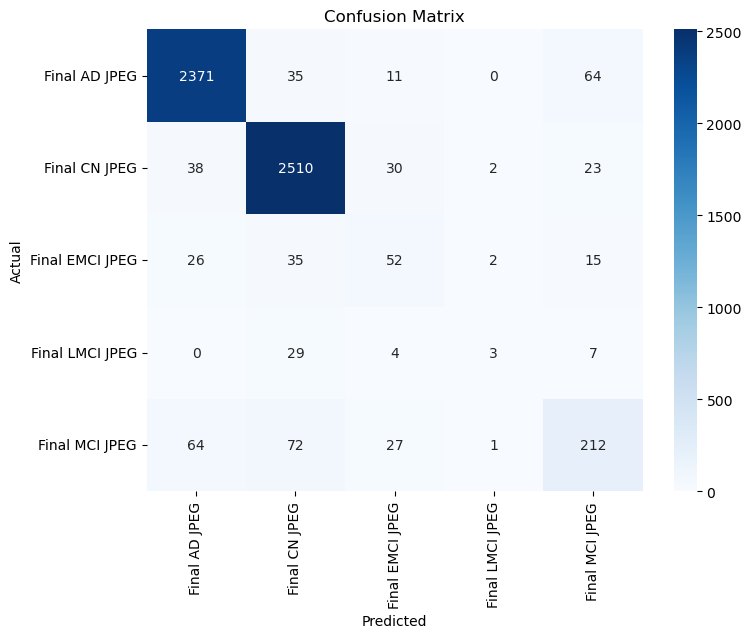

In [67]:
# Plot confusion matrix
cm = confusion_matrix(actual_classes, predictions_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [68]:
# Compile the model
model_resnet.compile(optimizer='adam', 
                     loss='categorical_crossentropy', 
                     metrics=['accuracy', 'precision', 'recall', tf.keras.metrics.AUC()])


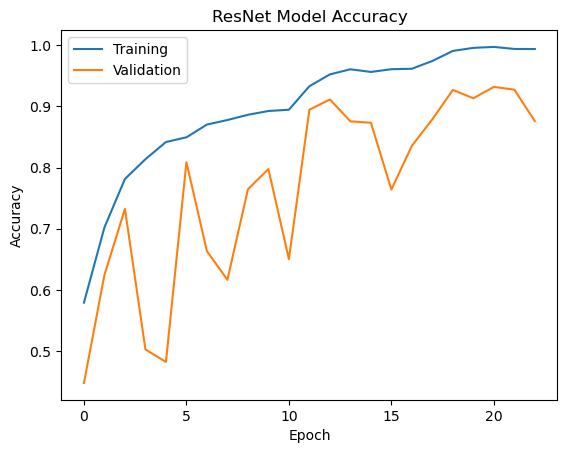

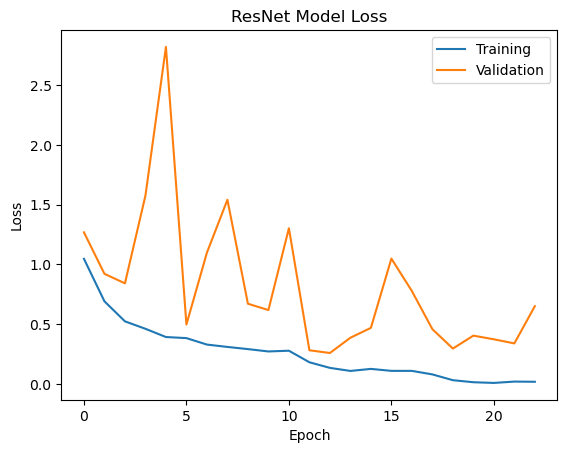

In [69]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ResNet Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.savefig('resnet_accuracy.png', dpi=300)
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('ResNet Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.savefig('resnet_loss.png', dpi=300)
plt.show()

177/177 [==============================] - 6s 29ms/step


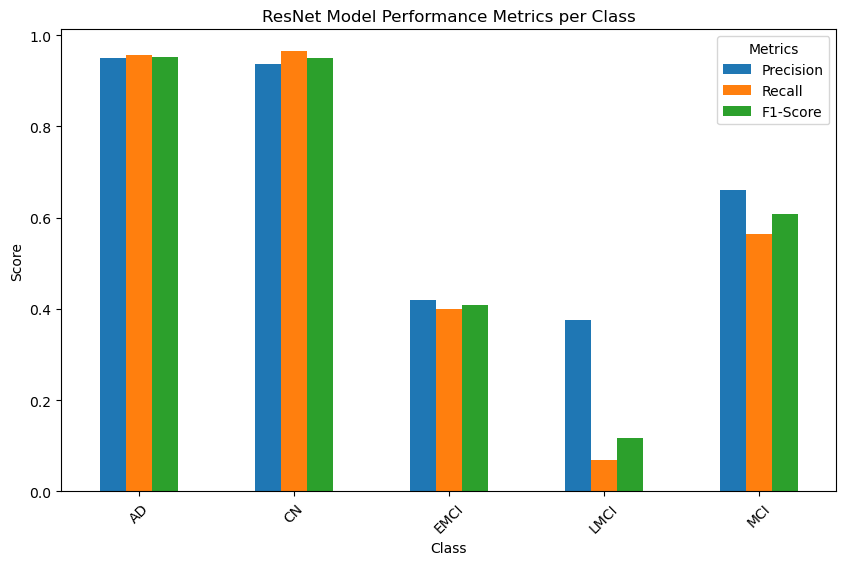

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Generate predictions for ResNet model
pred_resnet = model_resnet.predict(xtest)
pred_resnet = np.argmax(pred_resnet, axis=1)  # Convert probabilities to class labels
actual_label_resnet = np.argmax(ytest, axis=1)  # Get the true class labels from the test set

# Get metrics from ResNet classification report
report_resnet = classification_report(actual_label_resnet, pred_resnet, target_names=labels_final, output_dict=True)

# Extract precision, recall, and f1-score for ResNet
precision_resnet = [report_resnet[label]['precision'] for label in labels_final]
recall_resnet = [report_resnet[label]['recall'] for label in labels_final]
f1_score_resnet = [report_resnet[label]['f1-score'] for label in labels_final]

# Create a DataFrame for easier plotting
metrics_resnet_df = pd.DataFrame({
    'Class': labels_final,
    'Precision': precision_resnet,
    'Recall': recall_resnet,
    'F1-Score': f1_score_resnet
})

# Set the class names as index
metrics_resnet_df.set_index('Class', inplace=True)

# Plotting the performance metrics for ResNet
metrics_resnet_df.plot(kind='bar', figsize=(10, 6))
plt.title('ResNet Model Performance Metrics per Class')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(title='Metrics')
plt.savefig('resnet_model_performance_per_class.png', dpi=300)
plt.show()


In [71]:
# Save the model
model_resnet.save('resnet_model_final.h5')

Inception V3

In [72]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Initialize InceptionV3 model without pre-trained weights
inception_model = InceptionV3(weights=None, include_top=False, input_shape=(image_size, image_size, 3))

# Add custom layers for classification
x = inception_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dense(5, activation='softmax')(x)  # Change to 5 output classes

# Create the full model
model_inception = Model(inputs=inception_model.input, outputs=x)

# Compile the model
model_inception.compile(optimizer=Adam(learning_rate=0.0001), 
                        loss='categorical_crossentropy', 
                        metrics=['accuracy'])

# Train the model
history_inception = model_inception.fit(x_train, y_train, 
                                        validation_data=(x_test, y_test), 
                                        epochs=20, 
                                        batch_size=32, 
                                        verbose=1)

# Save the InceptionV3 model
model_inception.save('inception_v3_model.h5')


Epoch 1/20
411/411 [==============================] - 72s 95ms/step - loss: 0.8484 - accuracy: 0.5861 - val_loss: 0.7524 - val_accuracy: 0.6391
Epoch 2/20
411/411 [==============================] - 36s 89ms/step - loss: 0.6887 - accuracy: 0.6762 - val_loss: 0.6624 - val_accuracy: 0.6934
Epoch 3/20
411/411 [==============================] - 36s 88ms/step - loss: 0.5878 - accuracy: 0.7371 - val_loss: 0.6575 - val_accuracy: 0.6923
Epoch 4/20
411/411 [==============================] - 36s 89ms/step - loss: 0.4876 - accuracy: 0.7915 - val_loss: 0.4844 - val_accuracy: 0.7976
Epoch 5/20
411/411 [==============================] - 36s 89ms/step - loss: 0.4020 - accuracy: 0.8321 - val_loss: 0.6737 - val_accuracy: 0.7220
Epoch 6/20
411/411 [==============================] - 36s 88ms/step - loss: 0.3487 - accuracy: 0.8557 - val_loss: 0.6088 - val_accuracy: 0.7548
Epoch 7/20
411/411 [==============================] - 36s 88ms/step - loss: 0.3190 - accuracy: 0.8703 - val_loss: 0.3854 - val_accuracy:

In [73]:
# Make predictions on the test set
predictions_inception = model_inception.predict(x_test)

# Convert predictions to class labels
pred_inception = np.argmax(predictions_inception, axis=1)
actual_label_inception = np.argmax(y_test, axis=1)

# Get metrics from InceptionV3 classification report
report_inception = classification_report(actual_label_inception, pred_inception, target_names=labels_final, output_dict=True)

# Extract precision, recall, and f1-score for InceptionV3
precision_inception = [report_inception[label]['precision'] for label in labels_final]
recall_inception = [report_inception[label]['recall'] for label in labels_final]
f1_score_inception = [report_inception[label]['f1-score'] for label in labels_final]



177/177 [==============================] - 6s 26ms/step


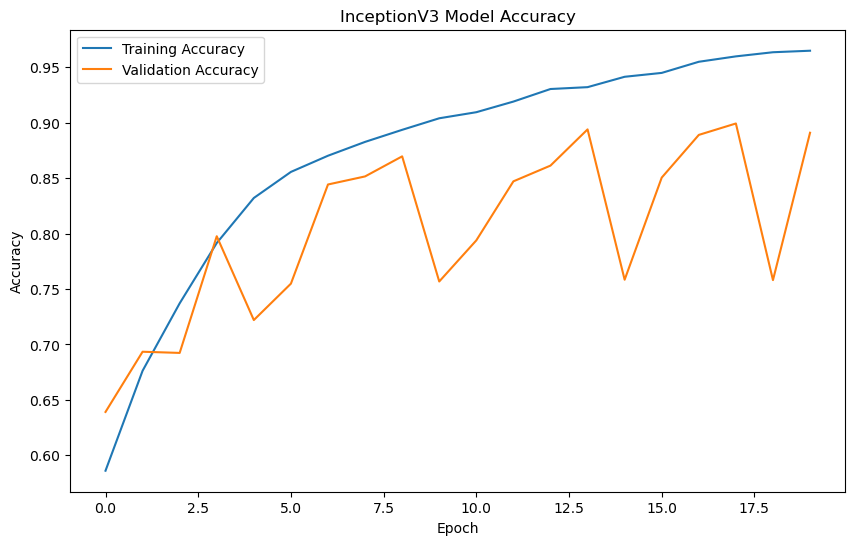

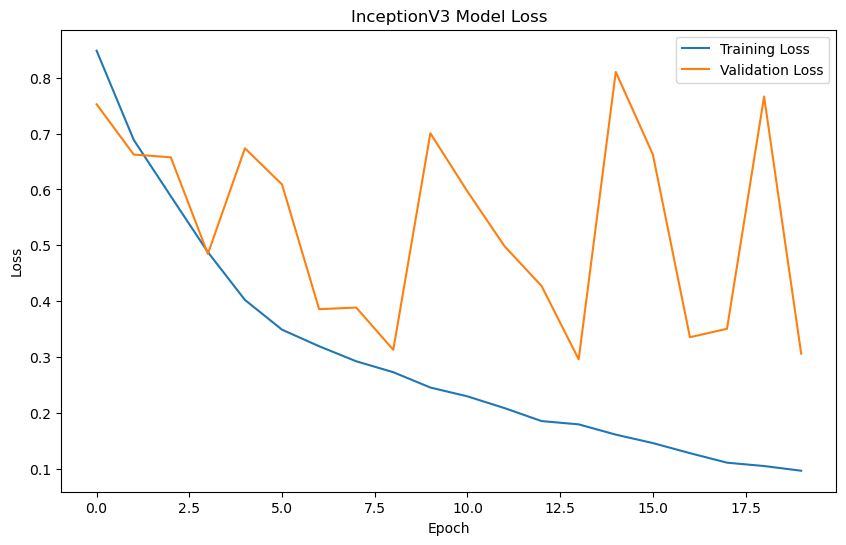

In [74]:
# Plot the training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history_inception.history['accuracy'], label='Training Accuracy')
plt.plot(history_inception.history['val_accuracy'], label='Validation Accuracy')
plt.title('InceptionV3 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('inceptionv3_accuracy.png', dpi=300)
plt.show()

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history_inception.history['loss'], label='Training Loss')
plt.plot(history_inception.history['val_loss'], label='Validation Loss')
plt.title('InceptionV3 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('inceptionv3_loss.png', dpi=300)
plt.show()


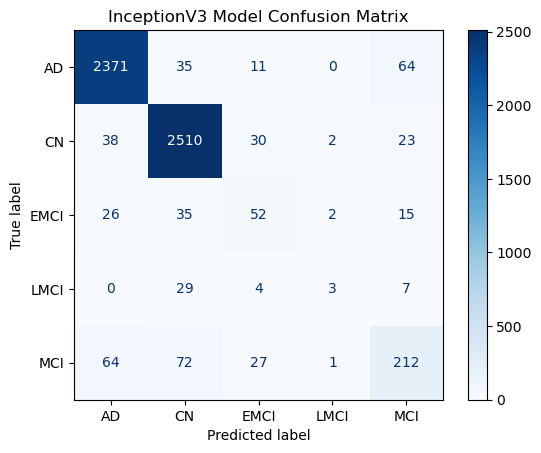

In [75]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculate the confusion matrix
confusion_mtx = confusion_matrix(actual_classes, predictions_classes)

# Create a confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx, display_labels=labels_final)
disp.plot(cmap=plt.cm.Blues)
plt.title('InceptionV3 Model Confusion Matrix')
plt.savefig('inceptionv3_confusion_matrix.png', dpi=300)
plt.show()


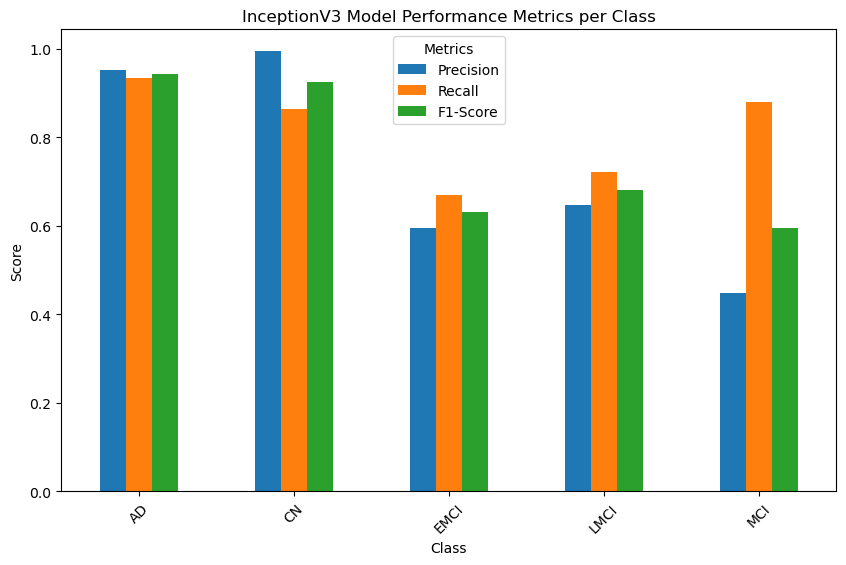

In [76]:
# Create a DataFrame for easier plotting
metrics_inception_df = pd.DataFrame({
    'Class': labels_final,
    'Precision': precision_inception,
    'Recall': recall_inception,
    'F1-Score': f1_score_inception
})

# Set the class names as index
metrics_inception_df.set_index('Class', inplace=True)

# Plotting the performance metrics for InceptionV3
metrics_inception_df.plot(kind='bar', figsize=(10, 6))
plt.title('InceptionV3 Model Performance Metrics per Class')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(title='Metrics')
plt.savefig('inceptionv3_model_performance_per_class.png', dpi=300)
plt.show()


## Comparison and Graphs of Different Model Types

In [77]:
scores  = model.evaluate(xtest, ytest, verbose=1)
scores1 = model1.evaluate(xtest, ytest, verbose=1)
scores2 = model2.evaluate(xtest, ytest, verbose=1)
scores3 = model3.evaluate(xtest, ytest, verbose=1)
# scores_resnet = model_resnet.evaluate(xtest, ytest, verbose=1)

177/177 [==============================] - 8s 41ms/step - loss: 2.7220 - accuracy: 0.9657 - precision: 0.9155 - recall: 0.9127 - auc: 0.9719


## Densenet 

In [78]:
precision = scores[0]
f1_score = scores[1]
recall = scores[2]
accuracy = scores[3]

## CNN 

In [79]:
precision1 = scores1[0]
f1_score1 = scores1[1]
recall1 = scores1[2]
accuracy1 = scores1[3]

## Efficient Net B7 

In [80]:
precision2 = scores2[0]
f1_score2 = scores2[1]
recall2 = scores2[2]
accuracy2 = scores2[3]

## VGG 19 

In [81]:
precision3 = scores3[0]
f1_score3 = scores3[1]
recall3 = scores3[2]
accuracy3 = scores3[3]

In [82]:
model_resnet.compile(optimizer='adam', 
                     loss='categorical_crossentropy', 
                     metrics=['accuracy'])

# Evaluate the ResNet model
scores_resnet = model_resnet.evaluate(xtest, ytest, verbose=1)

# Print the scores to understand their structure
print("ResNet Scores:", scores_resnet)

# Extract metrics based on the length of scores_resnet
if len(scores_resnet) >= 4:
    loss = scores_resnet[0]
    accuracy_resnet = scores_resnet[1]
    precision_resnet = scores_resnet[2]
    recall_resnet = scores_resnet[3]
else:
    loss = scores_resnet[0]
    accuracy_resnet = scores_resnet[1]
    # Handle missing precision and recall if not defined
    precision_resnet = None
    recall_resnet = None


177/177 [==============================] - 8s 33ms/step - loss: 0.2589 - accuracy: 0.9139
ResNet Scores: [0.25887274742126465, 0.9139002561569214]


In [83]:
# Generate predictions for ResNet model
pred_resnet = model_resnet.predict(xtest)


177/177 [==============================] - 6s 29ms/step


In [84]:
# Generate predictions for all models
pred_densenet = model.predict(xtest)         # Assuming 'model' is the DenseNet model
pred_cnn = model1.predict(xtest)             # Assuming 'model1' is your CNN model
pred_efficientnet = model2.predict(xtest)    # Assuming 'model2' is the EfficientNet model
pred_vgg19 = model3.predict(xtest)           # Assuming 'model3' is the VGG19 model
pred_resnet = model_resnet.predict(xtest)    # Assuming 'model_resnet' is the new ResNet model

# Create ensemble predictions including the ResNet model
ensemble_preds = np.average([pred_densenet, pred_cnn, pred_efficientnet, pred_vgg19, pred_resnet], axis=0)
final_preds = np.argmax(ensemble_preds, axis=1)
actual_label_final = np.argmax(ytest, axis=1)

# Print classification report for ensemble model
from sklearn.metrics import classification_report
print(classification_report(actual_label_final, final_preds, target_names=labels_final))


177/177 [==============================] - 5s 29ms/step
              precision    recall  f1-score   support

          AD       0.97      0.98      0.98      2481
          CN       0.96      0.99      0.98      2603
        EMCI       0.87      0.72      0.79       130
        LMCI       0.88      0.65      0.75        43
         MCI       0.92      0.78      0.84       376

    accuracy                           0.96      5633
   macro avg       0.92      0.82      0.87      5633
weighted avg       0.96      0.96      0.96      5633



In [85]:
# Create ensemble predictions including the ResNet model
ensemble_preds = np.average([pred_densenet, pred_cnn, pred_efficientnet, pred_vgg19, pred_resnet], axis=0)
final_preds = np.argmax(ensemble_preds, axis=1)
actual_label_final = np.argmax(ytest, axis=1)


In [86]:
import pandas as pd

# Create a DataFrame for evaluation
eval_df = pd.DataFrame(columns=['Model', 'Precision', 'F1 Score', 'Recall', 'Accuracy'])

In [87]:
# Add ResNet model metrics
# eval_df = eval_df.append({'Model': 'ResNet', 
#                           'Precision': precision_resnet, 
#                           'F1 Score': f1_score_resnet, 
#                           'Recall': recall_resnet, 
#                           'Accuracy': accuracy_resnet}, 
#                          ignore_index=True)

# Continue adding the other models (Densenet, CNN, EfficientNet, VGG19)
eval_df = eval_df.append({'Model': 'Densenet', 
                          'Precision': precision, 
                          'F1 Score': f1_score, 
                          'Recall': recall, 
                          'Accuracy': accuracy}, 
                         ignore_index=True)

eval_df = eval_df.append({'Model': 'CNN', 
                          'Precision': precision1, 
                          'F1 Score': f1_score1, 
                          'Recall': recall1, 
                          'Accuracy': accuracy1}, 
                         ignore_index=True)

eval_df = eval_df.append({'Model': 'Efficient Net B7', 
                          'Precision': precision2, 
                          'F1 Score': f1_score2, 
                          'Recall': recall2, 
                          'Accuracy': accuracy2}, 
                         ignore_index=True)

eval_df = eval_df.append({'Model': 'VGG 19', 
                          'Precision': precision3, 
                          'F1 Score': f1_score3, 
                          'Recall': recall3, 
                          'Accuracy': accuracy3}, 
                         ignore_index=True)

# Save evaluation DataFrame to CSV
eval_df.to_csv('comparison_metrics.csv', index=False)


In [88]:
eval_df

,Model,Precision,F1 Score,Recall,Accuracy
0,Densenet,0.292761,0.975359,0.939961,0.936623
1,CNN,0.574751,0.969785,0.925672,0.923043
2,Efficient Net B7,0.224937,0.973537,0.935543,0.931889
3,VGG 19,2.722047,0.965684,0.915465,0.912702


In [89]:
import csv
eval_df.to_csv('comparison_metrics.csv', index=False)

## Ensemble Learning

In [90]:
# # Generate predictions for all models 
# pred_densenet = model.predict(xtest)
# pred_cnn = model1.predict(xtest)
# pred_efficientnet = model2.predict(xtest)
# pred_vgg19 = model3.predict(xtest)

# # Create ensemble predictions using ResNet50
# ensemble_preds = np.average([pred_densenet, pred_cnn, pred_efficientnet, pred_vgg19], axis=0)
# final_preds = np.argmax(ensemble_preds, axis=1)
# actual_label_final = np.argmax(ytest, axis=1)

# # Print classification report
# from sklearn.metrics import classification_report
# print(classification_report(actual_label_final, final_preds, target_names=labels_final))

# Generate predictions for all models
pred_densenet = model.predict(xtest)
pred_cnn = model1.predict(xtest)
pred_efficientnet = model2.predict(xtest)
pred_vgg19 = model3.predict(xtest)
pred_resnet = model_resnet.predict(xtest)  # Add ResNet predictions

# Create ensemble predictions including the ResNet model
ensemble_preds = np.average([pred_densenet, pred_cnn, pred_efficientnet, pred_vgg19, pred_resnet], axis=0)
final_preds = np.argmax(ensemble_preds, axis=1)
actual_label_final = np.argmax(ytest, axis=1)

# Print classification report
from sklearn.metrics import classification_report
print(classification_report(actual_label_final, final_preds, target_names=labels_final))


177/177 [==============================] - 5s 29ms/step
              precision    recall  f1-score   support

          AD       0.97      0.98      0.98      2481
          CN       0.96      0.99      0.98      2603
        EMCI       0.87      0.72      0.79       130
        LMCI       0.88      0.65      0.75        43
         MCI       0.92      0.78      0.84       376

    accuracy                           0.96      5633
   macro avg       0.92      0.82      0.87      5633
weighted avg       0.96      0.96      0.96      5633



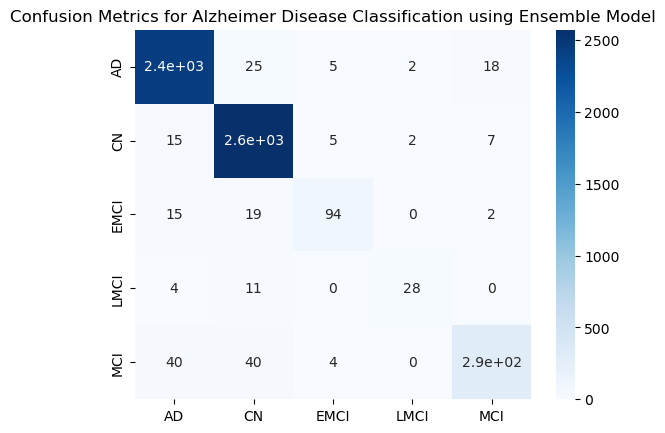

In [91]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix for ensemble predictions
Cm_ensemble = confusion_matrix(actual_label_final, final_preds)

# Plot the confusion matrix
ax_ensemble = plt.axes()
sns.heatmap(Cm_ensemble, cmap='Blues', annot=True, 
           annot_kws={'size':10},
           xticklabels=labels_final, 
           yticklabels=labels_final, 
           ax=ax_ensemble)
plt.title("Confusion Metrics for Alzheimer Disease Classification using Ensemble Model")
plt.savefig('ensemble_confusion.png', dpi=300)
plt.show()

In [92]:
import pickle
with open('/kaggle/input/model-training/Model Training/ensemble_history.pkl', 'rb') as f:
    final = pickle.load(f)

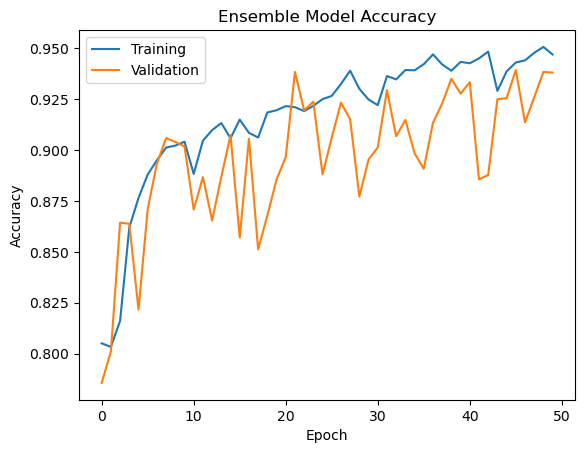

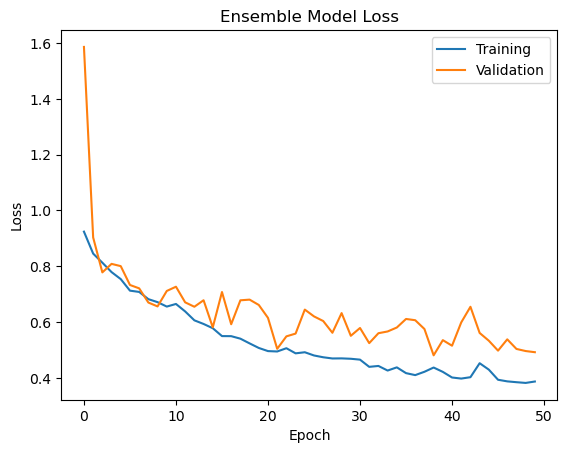

In [93]:
# Plot the training and validation accuracy
plt.plot(final['accuracy'])
plt.plot(final['val_accuracy'])
plt.title('Ensemble Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.savefig('ensemble_accuracy2.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation loss
plt.plot(final['loss'])
plt.plot(final['val_loss'])
plt.title('Ensemble Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.savefig('ensemble_loss2.png', dpi=300) # Save plot as PNG
plt.show()

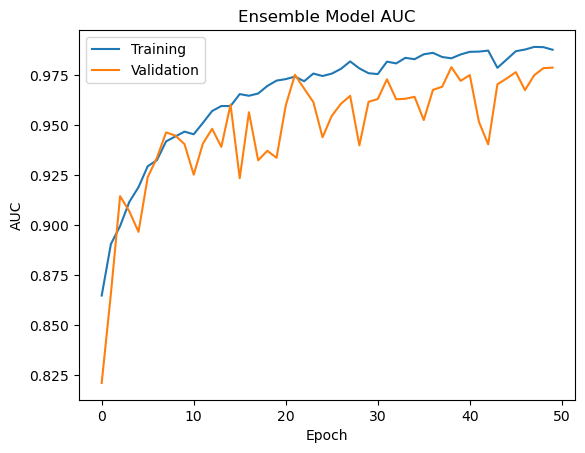

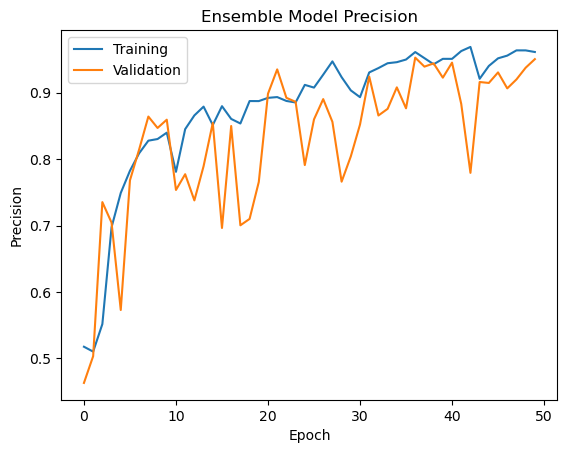

In [94]:
# Plot the training and validation auc
plt.plot(final['auc'])
plt.plot(final['val_auc'])
plt.title('Ensemble Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(['Training', 'Validation'])
plt.savefig('ensemble_auc2.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation precision
plt.plot(final['precision'])
plt.plot(final['val_precision'])
plt.title('Ensemble Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Training', 'Validation'])
plt.savefig('ensemble_precision2.png', dpi=300) # Save plot as PNG
plt.show()

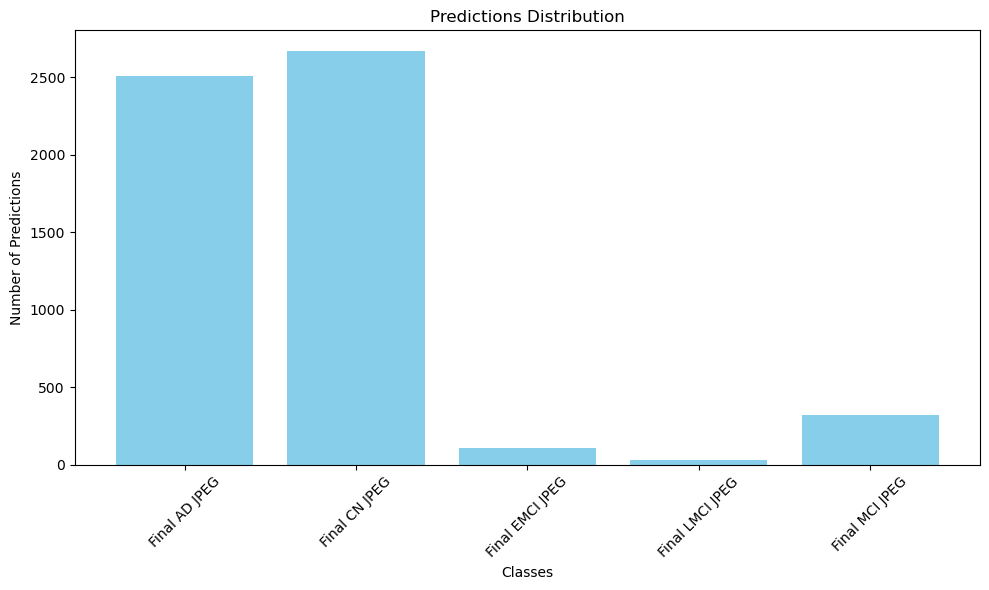

In [95]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'final_preds' contains your predictions
unique, counts = np.unique(final_preds, return_counts=True)
prediction_counts = dict(zip(unique, counts))

# Prepare data for plotting
classes = ['Final AD JPEG', 'Final CN JPEG', 'Final EMCI JPEG', 'Final LMCI JPEG', 'Final MCI JPEG']
prediction_values = [prediction_counts.get(i, 0) for i in range(len(classes))]

# Bar graph for predictions
plt.figure(figsize=(10, 6))
plt.bar(classes, prediction_values, color='skyblue')
plt.title('Predictions Distribution')
plt.xlabel('Classes')
plt.ylabel('Number of Predictions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('prediction_distribution.png', dpi=300)  # Save plot as PNG
plt.show()


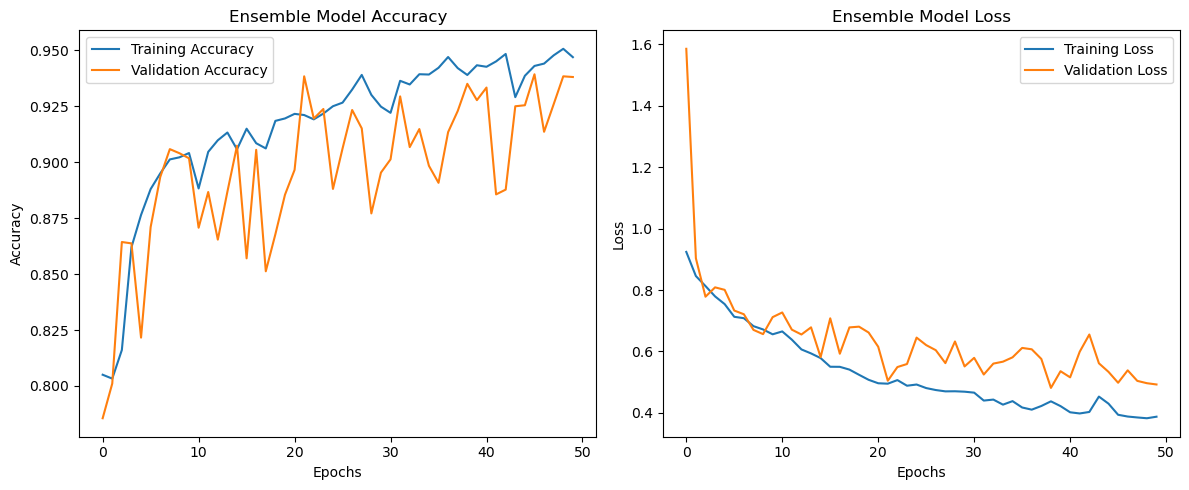

In [96]:
# Plot the training and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(final['accuracy'], label='Training Accuracy')
plt.plot(final['val_accuracy'], label='Validation Accuracy')
plt.title('Ensemble Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(final['loss'], label='Training Loss')
plt.plot(final['val_loss'], label='Validation Loss')
plt.title('Ensemble Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('ensemble_learning_curves.png', dpi=300)  # Save plot as PNG
plt.show()


Creating a Hybrid Model (ResNet + InceptionV3)

In [97]:
from tensorflow.keras.layers import Concatenate

# Load the trained ResNet and InceptionV3 models
# Assuming both ResNet and InceptionV3 are already trained from scratch
resnet_output = model_resnet.layers[-2].output  # Get output from ResNet before the final classification layer
inception_output = model_inception.layers[-2].output  # Get output from InceptionV3 before the final classification layer

# Concatenate the outputs from both models
combined = Concatenate()([resnet_output, inception_output])

# Add a dense layer and softmax output layer for 5 classes
x = Dense(128, activation='relu')(combined)
x = Dropout(0.5)(x)
x = Dense(5, activation='softmax')(x)  # Change to 5 output classes

# Create the hybrid model
hybrid_model = Model(inputs=[model_resnet.input, model_inception.input], outputs=x)

# Compile the hybrid model
hybrid_model.compile(optimizer=Adam(learning_rate=0.0001), 
                     loss='categorical_crossentropy', 
                     metrics=['accuracy'])

# Train the hybrid model
history_hybrid = hybrid_model.fit([x_train, x_train], y_train, 
                                  validation_data=([x_test, x_test], y_test), 
                                  epochs=10, 
                                  batch_size=32, 
                                  verbose=1)

# Save the hybrid model
hybrid_model.save('hybrid_resnet_inception_model.h5')


Epoch 1/10
411/411 [==============================] - 154s 212ms/step - loss: 0.1704 - accuracy: 0.9432 - val_loss: 0.2814 - val_accuracy: 0.9134
Epoch 2/10
411/411 [==============================] - 83s 201ms/step - loss: 0.0838 - accuracy: 0.9725 - val_loss: 0.2389 - val_accuracy: 0.9315
Epoch 3/10
411/411 [==============================] - 83s 201ms/step - loss: 0.0625 - accuracy: 0.9788 - val_loss: 0.2094 - val_accuracy: 0.9457
Epoch 4/10
411/411 [==============================] - 83s 201ms/step - loss: 0.0485 - accuracy: 0.9849 - val_loss: 0.3581 - val_accuracy: 0.9073
Epoch 5/10
411/411 [==============================] - 83s 201ms/step - loss: 0.0456 - accuracy: 0.9865 - val_loss: 0.2915 - val_accuracy: 0.9315
Epoch 6/10
411/411 [==============================] - 83s 201ms/step - loss: 0.0384 - accuracy: 0.9877 - val_loss: 0.2634 - val_accuracy: 0.9404
Epoch 7/10
411/411 [==============================] - 83s 201ms/step - loss: 0.0334 - accuracy: 0.9893 - val_loss: 0.2826 - val_a

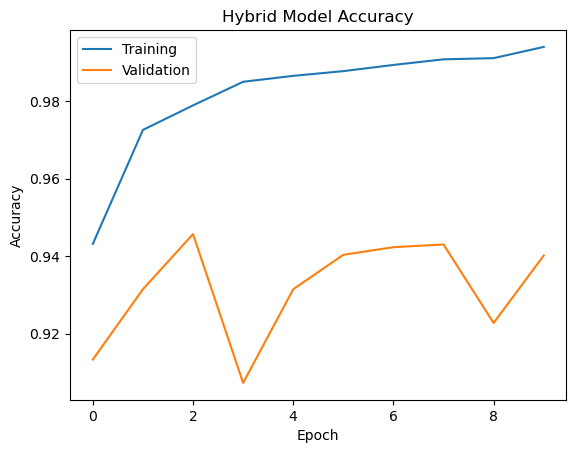

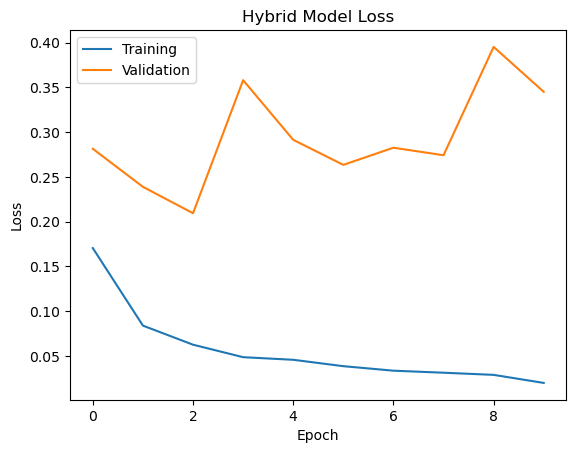

In [98]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history_hybrid.history['accuracy'])
plt.plot(history_hybrid.history['val_accuracy'])
plt.title('Hybrid Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.show()

# Plot loss
plt.plot(history_hybrid.history['loss'])
plt.plot(history_hybrid.history['val_loss'])
plt.title('Hybrid Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.show()


177/177 [==============================] - 12s 55ms/step
              precision    recall  f1-score   support

          AD       0.98      0.97      0.97      2481
          CN       0.98      0.97      0.98      2603
        EMCI       0.69      0.65      0.67       130
        LMCI       0.19      0.91      0.32        43
         MCI       0.88      0.66      0.76       376

    accuracy                           0.94      5633
   macro avg       0.74      0.83      0.74      5633
weighted avg       0.96      0.94      0.95      5633



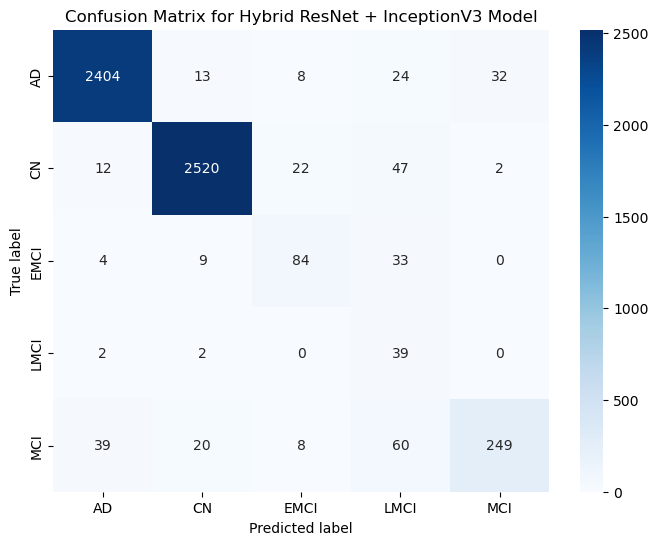

In [99]:
# Generate predictions using the hybrid model
hybrid_preds = hybrid_model.predict([xtest, xtest])
final_preds_hybrid = np.argmax(hybrid_preds, axis=1)
actual_labels_hybrid = np.argmax(ytest, axis=1)

# Classification report for hybrid model
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(actual_labels_hybrid, final_preds_hybrid, target_names=labels_final))

# Confusion matrix for hybrid model
cm_hybrid = confusion_matrix(actual_labels_hybrid, final_preds_hybrid)

# Plot the confusion matrix
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cm_hybrid, annot=True, cmap='Blues', fmt='d',
            xticklabels=labels_final, yticklabels=labels_final)
plt.title('Confusion Matrix for Hybrid ResNet + InceptionV3 Model')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


177/177 [==============================] - 10s 55ms/step


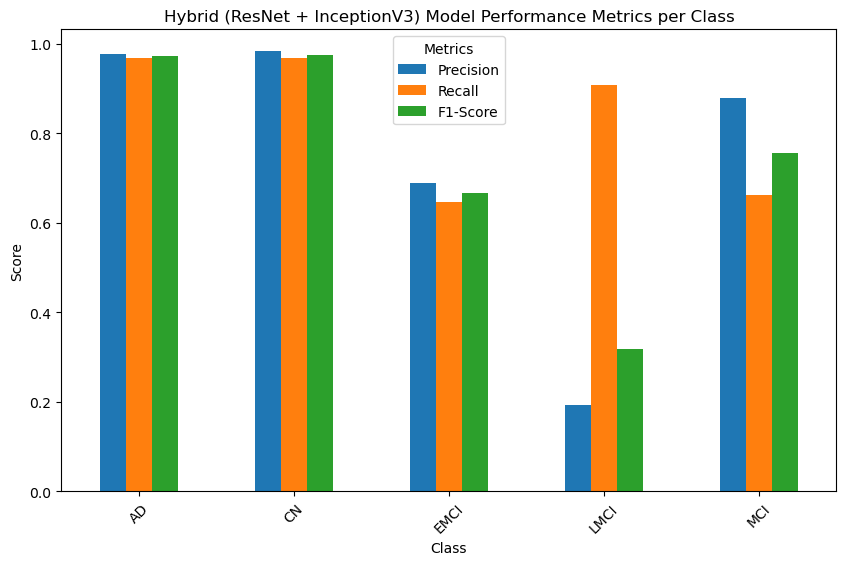

In [100]:
# Make predictions with the hybrid model
pred_hybrid_probs = hybrid_model.predict([x_test, x_test])  # Use the same test set for both inputs
pred_hybrid = np.argmax(pred_hybrid_probs, axis=1)  # Get the predicted class indices

# Assuming y_test is in categorical format, convert it back to class indices
actual_label_hybrid = np.argmax(y_test, axis=1)

# Get metrics from Hybrid model classification report
report_hybrid = classification_report(actual_label_hybrid, pred_hybrid, target_names=labels_final, output_dict=True)

# Extract precision, recall, and f1-score for the Hybrid model
precision_hybrid = [report_hybrid[label]['precision'] for label in labels_final]
recall_hybrid = [report_hybrid[label]['recall'] for label in labels_final]
f1_score_hybrid = [report_hybrid[label]['f1-score'] for label in labels_final]

# Create a DataFrame for easier plotting
metrics_hybrid_df = pd.DataFrame({
    'Class': labels_final,
    'Precision': precision_hybrid,
    'Recall': recall_hybrid,
    'F1-Score': f1_score_hybrid
})

# Set the class names as index
metrics_hybrid_df.set_index('Class', inplace=True)

# Plotting the performance metrics for Hybrid model
metrics_hybrid_df.plot(kind='bar', figsize=(10, 6))
plt.title('Hybrid (ResNet + InceptionV3) Model Performance Metrics per Class')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(title='Metrics')
plt.savefig('hybrid_model_performance_per_class.png', dpi=300)
plt.show()


177/177 [==============================] - 10s 55ms/step


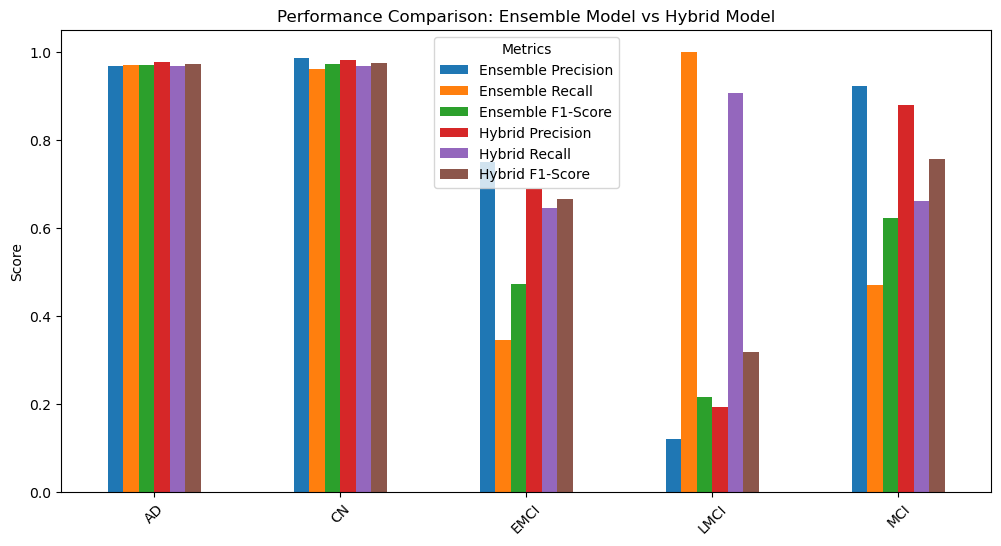

In [101]:
# Make predictions with the ensemble model (assuming you have a function for that)
# For example, you might average the predictions from ResNet and InceptionV3
# If using soft voting:
pred_ensemble_resnet = model_resnet.predict(x_test)
pred_ensemble_inception = model_inception.predict(x_test)

# Average the predictions (soft voting)
pred_ensemble = (pred_ensemble_resnet + pred_ensemble_inception) / 2
pred_ensemble_classes = np.argmax(pred_ensemble, axis=1)

# Make predictions with the hybrid model
pred_hybrid_probs = hybrid_model.predict([x_test, x_test])
pred_hybrid_classes = np.argmax(pred_hybrid_probs, axis=1)

# Get actual labels
actual_label = np.argmax(y_test, axis=1)

# Classification report for ensemble model
report_ensemble = classification_report(actual_label, pred_ensemble_classes, target_names=labels_final, output_dict=True)

# Classification report for hybrid model
report_hybrid = classification_report(actual_label, pred_hybrid_classes, target_names=labels_final, output_dict=True)

# Extract metrics for comparison
metrics_ensemble = {
    'Precision': [report_ensemble[label]['precision'] for label in labels_final],
    'Recall': [report_ensemble[label]['recall'] for label in labels_final],
    'F1-Score': [report_ensemble[label]['f1-score'] for label in labels_final],
}

metrics_hybrid = {
    'Precision': [report_hybrid[label]['precision'] for label in labels_final],
    'Recall': [report_hybrid[label]['recall'] for label in labels_final],
    'F1-Score': [report_hybrid[label]['f1-score'] for label in labels_final],
}

# Create DataFrames for easier plotting
metrics_ensemble_df = pd.DataFrame(metrics_ensemble, index=labels_final)
metrics_hybrid_df = pd.DataFrame(metrics_hybrid, index=labels_final)

# Combine metrics for plotting
combined_metrics_df = pd.concat([metrics_ensemble_df, metrics_hybrid_df], axis=1)
combined_metrics_df.columns = ['Ensemble Precision', 'Ensemble Recall', 'Ensemble F1-Score',
                                'Hybrid Precision', 'Hybrid Recall', 'Hybrid F1-Score']

# Plotting the performance comparison
combined_metrics_df.plot(kind='bar', figsize=(12, 6))
plt.title('Performance Comparison: Ensemble Model vs Hybrid Model')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(title='Metrics')
plt.savefig('model_comparison_performance.png', dpi=300)
plt.show()


## Mean Square Error 

In [102]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming pred, pred1, pred2, pred3 are 1D arrays with class probabilities
pred_final1 = (pred + pred1 + pred2 + pred3) / 4.0

# Check if it's binary or multi-class
if len(pred_final1.shape) == 1:  # If it's a flat array
    # For binary classification, use thresholding
    final_predictions = (pred_final1 > 0.5).astype(int)
else:
    # For multi-class classification, apply argmax
    final_predictions = np.argmax(pred_final1, axis=1)

# If ytest is one-hot encoded, convert it to class labels
if ytest.ndim > 1:  # Check if it's one-hot encoded
    actual_labels = np.argmax(ytest, axis=1)
else:
    actual_labels = ytest  # Already in class label format

# Calculate and print the mean squared error
mse = mean_squared_error(actual_labels, final_predictions)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 0.6918160837919404


In [103]:
# Assuming pred, pred1, pred2, pred3 are your individual predictions (2D arrays)
# For example, they might be of shape (num_samples, num_classes)
pred_final1 = (pred + pred1 + pred2 + pred3) / 4.0

# Check shapes
print("ytest shape:", ytest.shape)
print("pred_final1 shape:", pred_final1.shape)

# If ytest is already in single-label format
if len(ytest.shape) == 1:
    ytest_single = ytest
else:
    ytest_single = np.argmax(ytest, axis=1)

# If pred_final1 is still in probability form and 2D
if len(pred_final1.shape) == 2:
    pred_final_labels = np.argmax(pred_final1, axis=1)
else:
    pred_final_labels = pred_final1  # Assume it's already class labels

# Calculate mean squared error
mse = mean_squared_error(ytest_single, pred_final_labels)
print("Mean Squared Error:", mse)


ytest shape: (5633, 5)
pred_final1 shape: (5633,)
Mean Squared Error: 0.23123779513580686


## Prediction

In [104]:
def imagePrediction(upload):
    for name, fileinfo  in uploader.value.items():
        image = Image.open(io.BytesIO(fileinfo['content']))
        
    images = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    images = cv2.resize(images,(150, 150))
    images = images.reshape(1, 150, 150, 3)
    prd = model2.predict(images)
    prd = np.argmax(prd, axis = 1)[0]
    
    
    if prd == 0:
        prd = "Final AD JPEG"
    elif prd == 1:
        prd = "Final CN JPEG"
    elif prd == 2:
        prd = "Final EMCI JPEG"
    elif prd == 3:
        prd = "Final LMCI JPEG"
    elif prd == 4:
        prd = "Final MCI JPEG"
    if prd!=1:
        print(f'Model Predict That is  a {prd}')
    

In [107]:
uploader = widgets.FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

In [108]:
button = widgets.Button(description= "Predict")
out = widgets.Output()

def on_button_click(_):
    with out:
        clear_output()
        try:
            imagePrediction(uploader)
        except:
            print("Please Enter the Correct Image files")
            
            
button.on_click(on_button_click)
widgets.VBox([button, out])
